In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
from IPython.display import clear_output  # 引入 clear_output
# torch.manual_seed(seed=42)  

os.makedirs("fun_images", exist_ok=True)


In [33]:
layer_num=4
hidden_num=128

class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [34]:
def potential(x):
    x=100-x
    poten=-10/x-10*torch.sin(torch.pi*x/24)/x
    return poten

In [35]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.makedirs(f'./model_para_{layer_num}_{hidden_num}_{dtype}', exist_ok=True)
La =0
Lb =100
L=Lb-La  # domain length
N = 4000   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device,requires_grad=True)
grid=grid[1:-1].unsqueeze(-1)

en_num=100
extend_num=0

# 先给出固定的矩阵元素
diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap


In [36]:
# 读取模型参数
model_path=f'./potential_NN/potential_NN_f6_2.pt'
model = Mynetwork().to(device=device,dtype=dtype)
model.load_state_dict(torch.load(model_path))
model.eval()

/tmp/ipykernel_2192032/1583198826.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Mynetwork(
  (MLP): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
)

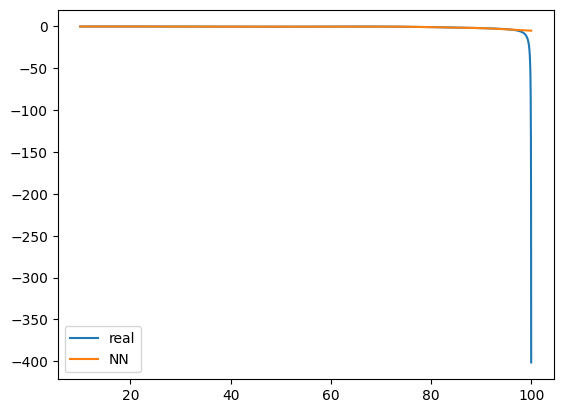

In [37]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[400:-1].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid)
real_poten=real_poten.cpu().detach().numpy()
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

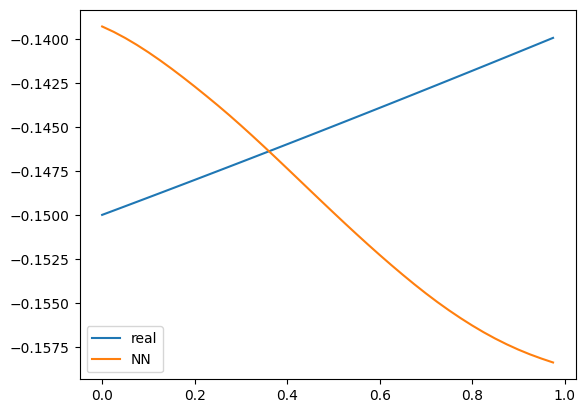

In [38]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[:40].unsqueeze(-1)
V_NN=model(grid)
V_NN=V_NN.cpu().detach().numpy()
real_poten=potential(grid)
real_poten=real_poten.cpu().detach().numpy()
plt.plot(grid.cpu().detach().numpy(),real_poten,label='real')
plt.plot(grid.cpu().detach().numpy(),V_NN,label='NN')
plt.legend()
plt.show()

In [39]:
# 计算本征值
en_num=80
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
model_en=eigenvalues[:en_num]

V_diag=potential(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
real_en=eigenvalues[:en_num]    

print('NN:',model_en)
print('real:',real_en)

error_fn=nn.L1Loss()
error_list=[]
for i in range(7):
    error=error_fn(model_en[:(i+1)*10],real_en[:(i+1)*10])
    error_list.append(error.item())


NN: tensor([-4.1850, -3.5161, -2.9680, -2.4863, -2.0694, -1.7400, -1.4758, -1.2516,
        -1.0518, -0.8684, -0.6970, -0.5349, -0.3805, -0.2356, -0.2192, -0.1748,
        -0.1447, -0.1192, -0.1178, -0.0983, -0.0803, -0.0621, -0.0569, -0.0426,
        -0.0235, -0.0063,  0.0080,  0.0258,  0.0455,  0.0671,  0.0901,  0.1146,
         0.1404,  0.1673,  0.1956,  0.2252,  0.2559,  0.2880,  0.3213,  0.3557,
         0.3910,  0.4277,  0.4657,  0.5045,  0.5447,  0.5860,  0.6283,  0.6717,
         0.7163,  0.7620,  0.8088,  0.8567,  0.9057,  0.9556,  1.0069,  1.0590,
         1.1123,  1.1666,  1.2220,  1.2784,  1.3360,  1.3945,  1.4543,  1.5148,
         1.5764,  1.6391,  1.7033,  1.7678,  1.8342,  1.9000,  1.9686,  2.0370,
         2.1074,  2.1791,  2.2506,  2.3240,  2.3975,  2.4728,  2.5490,  2.6261],
       device='cuda:0', grad_fn=<SliceBackward0>)
real: tensor([-5.0551e+01, -1.3759e+01, -6.8471e+00, -4.4070e+00, -3.2510e+00,
        -2.5857e+00, -2.1391e+00, -1.8012e+00, -1.5241e+00, -1.284

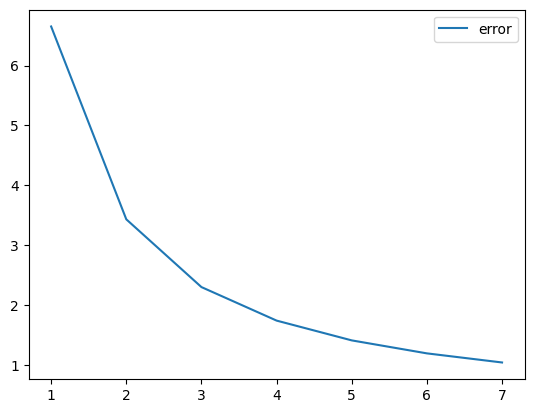

In [40]:
plt.plot(range(1,8),error_list,label='error')
plt.legend()
plt.show()